In [1]:
BATCH_SIZE = 4
EDGE_CROP = 2
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

In [2]:
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import numpy as np # linear algebra
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
data_dir = 'dataset'
train_image_dir = os.path.join(data_dir, 'train')
test_image_dir = os.path.join(data_dir, 'test')
import gc; gc.enable() # memory is tight
from skimage.morphology import label
import tensorflow as tf

c:\users\arindam baidya\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def get_all_imgs():
    img_path = os.path.join(train_image_dir,'images')
    images = glob.glob(os.path.join(img_path,'*.*'))
#     masks = glob.glob(os.path.join(mask_path,'*.*'))
    return [image.split('\\')[-1] for image in images]

In [4]:
# print(get_all_imgs())
TRAIN_IMGS, TEST_IMGS = train_test_split(get_all_imgs())

In [5]:
import random
def cv2_brightness_augment(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    seed = random.uniform(0.5,1.2)
    v = (( v/255.0 ) * seed)*255.0
    hsv[:,:,2] = np.array(np.clip(v,0,255),dtype=np.uint8)
    rgb_final = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_final
    

In [6]:
def make_image_gen(img_file_list=TRAIN_IMGS, batch_size = BATCH_SIZE):
    all_batches = TRAIN_IMGS
    out_rgb = []
    out_mask = []
    img_path = os.path.join(train_image_dir,'images')
    mask_path = os.path.join(train_image_dir,'masks')
    while True:
        np.random.shuffle(all_batches)
        for c_img_id in all_batches:
            c_img = imread(os.path.join(img_path,c_img_id))
            c_img = cv2_brightness_augment(c_img)
            c_mask = imread(os.path.join(mask_path,c_img_id))
            if IMG_SCALING is not None:
                c_img = cv2.resize(c_img,(256,256),interpolation = cv2.INTER_AREA)
                c_mask = cv2.resize(c_mask,(256,256),interpolation = cv2.INTER_AREA)
            c_mask = np.reshape(c_mask,(c_mask.shape[0],c_mask.shape[1],-1))
            c_mask = c_mask > 0
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

## Make Training Set

In [7]:
train_gen = make_image_gen()
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 256, 256, 3) 0.0 0.8274509803921568
y (4, 256, 256, 1) False True


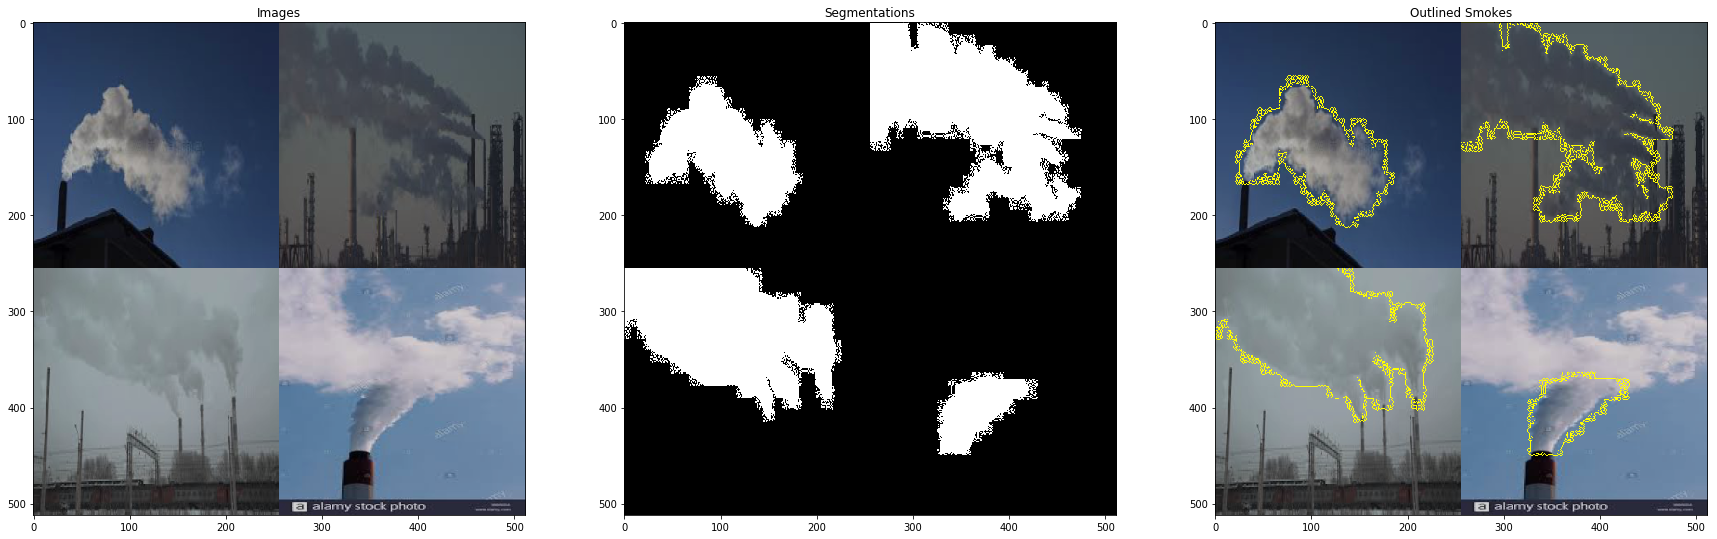

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg,cmap='gray')
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Smokes')
fig.savefig('overview.png')

## Make Validation Set

In [9]:
valid_x, valid_y = next(make_image_gen(TEST_IMGS,len(TEST_IMGS)))
print(valid_x.shape, valid_y.shape)

(84, 256, 256, 3) (84, 256, 256, 1)


## Augment Data

In [10]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

Using TensorFlow backend.


x (4, 256, 256, 3) float32 0.0 0.9254902
y (4, 256, 256, 1) float32 0.0 1.0


Text(0.5,1,'smoke')

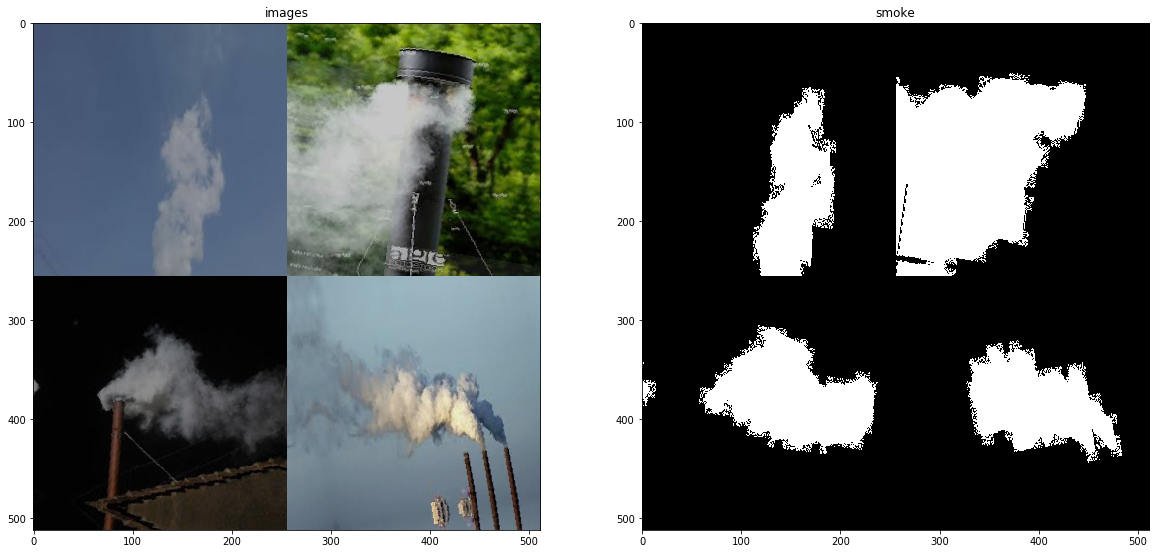

In [11]:

cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
ax2.set_title('smoke')

In [12]:
gc.collect()

20

## Build a Model
### Here we use Linknet <https://www.kaggle.com/kmader/keras-linknet>

In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, Deconv2D, MaxPool2D, concatenate, AvgPool2D, Lambda, Dropout
network_mode = 'bn'
s_c2 = lambda fc, k, s = 1, activation='elu', **kwargs: Conv2D(fc, kernel_size = (k,k), strides= (s,s),
                                       padding = 'same', activation = activation,
                                       **kwargs)
s_d2 = lambda fc, k, s = 1, activation='elu', **kwargs: Deconv2D(fc, kernel_size=(k,k), strides=(s,s), 
                                                       padding = 'same', activation=activation,
                                                       **kwargs)
if network_mode == 'bn':
    from keras.layers import BatchNormalization, Activation
    c2 = lambda fc, k, s = 1, **kwargs: lambda x: Activation('elu')(BatchNormalization()(
        Conv2D(fc, kernel_size = (k,k), strides= (s,s),
               padding = 'same', activation = 'linear', **kwargs)(x)))

    d2 = lambda fc, k, s = 1, **kwargs: lambda x: Activation('elu')(BatchNormalization()(
        Deconv2D(fc, kernel_size=(k,k), strides=(s,s), 
                 padding = 'same', activation='linear', **kwargs)(x)))
else:
    c2 = s_c2
    d2 = s_d2

In [14]:
# Build U-Net model
start_in = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name = 'Input')
start_scale = Lambda(lambda x: x / 255) (start_in)
# pre-processing
in_filt = c2(64, 7, 2)(start_scale)
in_mp = MaxPool2D((3,3), strides = (2,2), padding = 'same')(in_filt)

In [15]:
from keras import backend as K
from keras.regularizers import l2
from keras.layers import add

def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def enc_block(m, n):
    def block_func(x):
        cx = c2(n, 3)(c2(n, 3, 2)(x))
        cs1 = concatenate([AvgPool2D((2,2))(x), 
                           cx])
        cs2 = c2(n, 3)(c2(n, 3)(cs1))
        return concatenate([cs2, cs1])
    return block_func
def dec_block(m, n):
    def block_func(x):
        cx1 = c2(m//4, 1)(x)
        cx2 = d2(m//4, 3, 2)(cx1)
        return Dropout(0.1)(c2(n, 1)(cx2))
    return block_func

In [16]:
enc1 = enc_block(64, 64)(in_mp)
enc2 = enc_block(64, 128)(enc1)

dec2 = dec_block(64, 128)(enc2)
dec2_cat = _shortcut(enc1, dec2)
dec1 = dec_block(64, 64)(dec2_cat)

last_out = _shortcut(dec1, in_mp)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
# post-processing
out_upconv = d2(32, 3, 2)(last_out)
out_conv = c2(32, 3)(out_upconv)
out = s_d2(1, 2, 2, activation = 'sigmoid')(out_conv)

In [18]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [19]:
seg_model = Model(inputs = [start_in], outputs = [out]) 
seg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 256, 256, 3)   0           Input[0][0]                      
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 64)  9472        lambda_1[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 128, 64)  256         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [20]:
from keras import backend as K
from keras.metrics import binary_crossentropy
smooth = 1.

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def bce_dice(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)-K.log(dice_coef(y_true, y_pred))

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer = 'adam', 
              loss = bce_dice, 
              metrics = ['binary_accuracy', dice_coef, true_positive_rate])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [21]:
# Fit model
from  keras.callbacks  import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

step_count = min(MAX_TRAIN_STEPS, len(TRAIN_IMGS)//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen())
val_gen = make_image_gen(TEST_IMGS, len(TEST_IMGS)//BATCH_SIZE)
earlyStopper = EarlyStopping(monitor="val_dice_coef", mode="max", patience=15)
checkPointer = ModelCheckpoint('model-linknet.h5', monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
loss_history = [seg_model.fit_generator(aug_gen,
                            steps_per_epoch=step_count, 
                            epochs=NB_EPOCHS, 
                            validation_data=val_gen,
                            validation_steps=len(TEST_IMGS)//BATCH_SIZE, 
                            callbacks=[earlyStopper, reduceLROnPlat, checkPointer],
                            workers=1)]


Epoch 1/20
62/62 [==============================] - 178s - loss: 1.7959 - binary_accuracy: 0.6228 - dice_coef: 0.3441 - true_positive_rate: 0.6232 - val_loss: 2.2924 - val_binary_accuracy: 0.2496 - val_dice_coef: 0.3498 - val_true_positive_rate: 0.9954
Epoch 2/20
62/62 [==============================] - 181s - loss: 1.4567 - binary_accuracy: 0.7226 - dice_coef: 0.4339 - true_positive_rate: 0.7402 - val_loss: 3.4253 - val_binary_accuracy: 0.2565 - val_dice_coef: 0.3715 - val_true_positive_rate: 0.9991
Epoch 3/20
62/62 [==============================] - 174s - loss: 1.3561 - binary_accuracy: 0.7599 - dice_coef: 0.4527 - true_positive_rate: 0.7096 - val_loss: 3.3250 - val_binary_accuracy: 0.2746 - val_dice_coef: 0.3797 - val_true_positive_rate: 0.9935
Epoch 4/20
62/62 [==============================] - 171s - loss: 1.2754 - binary_accuracy: 0.7813 - dice_coef: 0.4770 - true_positive_rate: 0.6944 - val_loss: 3.1931 - val_binary_accuracy: 0.2582 - val_dice_coef: 0.3738 - val_true_positive_r

KeyboardInterrupt: 

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('DICE')

show_loss(loss_history)

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [ ]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

## Prepare Full Resolution Model

In [ ]:
# if IMG_SCALING is not None:
#     fullres_model = models.Sequential()
#     fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
#     fullres_model.add(seg_model)
#     fullres_model.add(layers.UpSampling2D(IMG_SCALING))
# else:
#     fullres_model = seg_model
# fullres_model.save('fullres_model.h5')

## Run the test data

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

In [ ]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = cv2.resize(c_img,(256,256))
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = seg_model.predict(first_img)
    first_img[0][:,:,0] = (first_img[0][:,:,0]*0.7 + 0.5*first_seg[0, :, :, 0])
    result = np.array(np.clip(first_img[0]*255.,0,255),dtype=np.int32)
    ax1.imshow(result)
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1, cmap='gray')
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

In [ ]:
from moviepy.editor import VideoFileClip
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_shape = image.shape[:2]
#     print(image_shape)
    image = cv2.resize(image,(256,256))
    first_img = np.expand_dims(image, 0)/255.0
#     result = image_pipeline(image)
    first_seg = seg_model.predict(first_img)
    first_img[0][:,:,0] = first_img[0][:,:,0]*0.7 + 0.3*first_seg[0, :, :, 0]
    result = np.array(np.clip(first_img[0]*255,0,255),dtype=np.float)
#     print(image_shape[:2],result.shape,type(result[0][0][0]))
    result = cv2.resize(result,image_shape[::-1])
#     result = result[...,::-1]
    
    return result

In [ ]:
filename='videoplayback_2.mp4'
clip = VideoFileClip(filename)
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(filename.split('.')[0]+'_detection.mp4', audio=False)

In [ ]:
def get_video(src):
    def pred_gen(src):
        ret = True
        while ret:
            ret, image = cv2.videoCapture(src)
            image = cv2.resize(image,(256,256))
            yield image
    return pred_gen
def make_video():
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter('videoplayback_out.mp4',fourcc, 25.0, (360,640))
    video_gen = get_video('videoplayback.mp4')
    resultant_clips = seg_model.predict_generator(video_gen)
    print('Prediction complete')
    for frame in resultant_clips:
        out.write(frame)
    out.release()
    print('Video written')
make_video()